In [2]:
import os
import json
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer
from dataclasses import dataclass, field
from typing import List, Tuple
from tqdm import tqdm


data_dir = 'D:/ComputerScience/cs_2024_Fall_Deep_Learning/Lab/data/Yelp'

In [5]:
def read_json(file_path):
        """
        Load training/test data from the specified directory
        :param data_dir: Directory containing the data files
        :param train: Whether to load the training data
        :return: List of data instances
        """
        word_counts = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                rdata = json.loads(line)
                text = rdata.get('text', None)
                star = rdata.get('stars', None)               
                word_counts.append(len(text.split()))
        return word_counts
file_path = os.path.join(data_dir, 'train.json')
word_counts = read_json(file_path)
print(max(word_counts))

1006


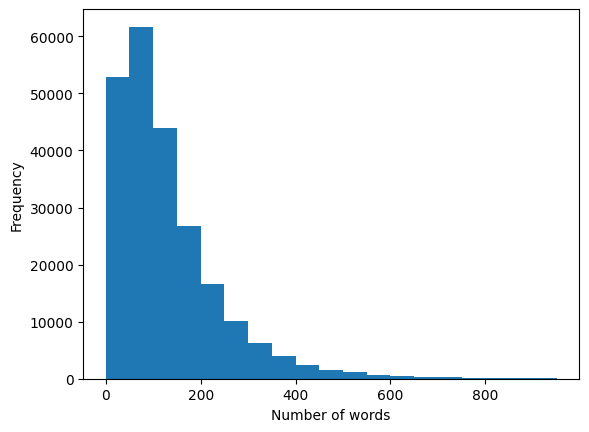

In [6]:
import matplotlib.pyplot as plt
plt.hist(word_counts, bins=range(0, 1000, 50))
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Histogram of number of words in Yelp reviews(train)')
plt.show()


In [2]:
# Define the data structure
@dataclass
class YelpData:
    text: str
    star: int

class YelpDataset(Dataset):
    def __init__(self, data_dir, tokenizer, train=True, max_length=512, reload_=False):
        """
        Dataset constructor
        :param data_dir: Directory of the data files
        :param train: Whether to load training data
        :param tokenizer_name: Name of the tokenizer to use
        :param max_length: Maximum length for padding and truncation
        """
        self.data_path = os.path.join(data_dir, 'train.json') if train else os.path.join(data_dir, 'test.json')
        self.raw_data = self._read_json(self.data_path)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = None
        if reload_:
            if train:
                save_path = os.path.join(data_dir, 'train.pt')
            else:
                save_path = os.path.join(data_dir, 'test.pt')
            if not os.path.exists(save_path):
                print("Preprocessed data not found, preprocessing...")
                self.data = self._preprocess(self.raw_data)
                torch.save(self.data, save_path)
                print(f"Preprocessed data saved to {save_path}")
            else:
                self.data = torch.load(save_path)
                print(f"Preprocessed data loaded from {save_path}")
    
    def _read_json(self, file_path):
        """
        Load training/test data from the specified directory
        :param data_dir: Directory containing the data files
        :param train: Whether to load the training data
        :return: List of data instances
        """
        data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    rdata = json.loads(line)
                    text = rdata.get('text', None)
                    star = rdata.get('stars', None)
                    
                    if text is not None and star is not None:
                        data.append(YelpData(text=text, star=star))
                    else:
                        print(f"{line_num} data is invalid")
                except json.JSONDecodeError as e:
                    print(f"Fails to decode line {line_num}")
        
        return data
    
    def _preprocess(self, raw_data):
        tokenizer_list = []
        mask_list = []
        label_list = []
        with tqdm(total=len(raw_data), desc="Preprocessing data") as pbar:
            for review in raw_data:
                text = review.text
                label = review.star - 1 # Convert 1-5 to 0-4
                
                # Tokenize, pad and truncate the text
                encoding = self.tokenizer(
                    text,
                    add_special_tokens=True,  # Add [CLS] and [SEP]
                    truncation=True,  # Truncate text if it exceeds max_length
                    padding='max_length',  # Pad text to max_length
                    max_length=self.max_length,
                    return_attention_mask=True,
                    return_tensors='pt'  # Return PyTorch tensors
                )
                
                tokenizer_list.append(encoding['input_ids'].squeeze(0))
                mask_list.append(encoding['attention_mask'].squeeze(0))
                label_list.append(torch.tensor(label, dtype=torch.long))
                pbar.update(1)
        
        return {
            'input_ids': torch.stack(tokenizer_list),
            'attention_mask': torch.stack(mask_list),
            'label': torch.stack(label_list)
        }


    def __len__(self):
        return len(self.raw_data)
    
    def __getitem__(self, idx):
        if self.data is None:
            text = self.raw_data[idx].text
            label = self.raw_data[idx].star
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_attention_mask=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            input_ids = self.data['input_ids'][idx]
            attention_mask = self.data['attention_mask'][idx]
            label = self.data['label'][idx]
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            }


In [3]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
train_dataset = YelpDataset(data_dir, tokenizer, reload_=True)
print(f"Number of training samples: {len(train_dataset)}")
test_dataset = YelpDataset(data_dir, tokenizer, train=False, reload_=True)
print(f"Number of test samples: {len(test_dataset)}")

Preprocessed data not found, preprocessing...


Preprocessing data: 100%|██████████| 229907/229907 [01:39<00:00, 2301.60it/s]


Preprocessed data saved to D:/ComputerScience/cs_2024_Fall_Deep_Learning/Lab/data/Yelp\train.pt
Number of training samples: 229907
Preprocessed data not found, preprocessing...


Preprocessing data: 100%|██████████| 1000/1000 [00:00<00:00, 2240.03it/s]

Preprocessed data saved to D:/ComputerScience/cs_2024_Fall_Deep_Learning/Lab/data/Yelp\test.pt
Number of test samples: 1000


C:\Users\runze\AppData\Local\Temp\ipykernel_22576\1163981945.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


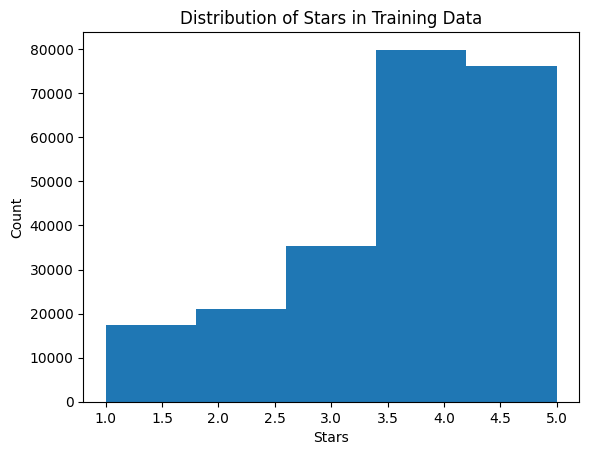

In [4]:
stars = [data['label']+1 for data in train_dataset]
import matplotlib.pyplot as plt
plt.hist(stars, bins=5)
plt.xlabel('Stars')
plt.ylabel('Count')
plt.title('Distribution of Stars in Training Data')
plt.show()

In [5]:
spilt_ratio = 0.8
train_size = int(spilt_ratio * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [8]:
@dataclass
class Config:
    embedding_dim: int
    hidden_dim: int
    output_dim: int
    n_layers: int
    dropout: float
    batch_size: int
    learning_rate: float
    max_length: int
    epochs: int


config = Config(
    embedding_dim=128,
    hidden_dim=128,
    output_dim=5,
    n_layers=2,
    dropout=0.5,
    batch_size=8,
    learning_rate=1e-3,
    max_length=512,
    epochs=5
)


In [9]:
class TextRNN(nn.Module):
    def __init__(self, config):
        super(TextRNN, self).__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.hidden_dim, num_layers=config.n_layers, dropout=config.dropout, batch_first=True)
        self.fc = nn.Linear(config.hidden_dim, config.output_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)
        rnn_out, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1])  # Last hidden state
        output = self.fc(hidden)
        return output


class TextRNNLightning(LightningModule):
    def __init__(self, config, model=None):
        super(TextRNNLightning, self).__init__()
        self.save_hyperparameters(ignore='model')
        self.config = config
        self.model = model if model else TextRNN(config)

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = self(input_ids, attention_mask)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)
        return optimizer


NameError: name 'LightningModule' is not defined